In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pypsa
import yaml
import pandas as pd

import model

In [2]:
networks = {"Default": pypsa.Network("models/LYR_2011_2019.nc"),
            "No thermal storage": pypsa.Network("models/LYR_2011_2019_no_thermal_storage.nc"),
            "Expensive thermal storage": pypsa.Network("models/LYR_2011_2019_exp_thermal_storage.nc"),
            "Low efficiency heat pump": pypsa.Network("models/LYR_2011_2019_bad_heat_pump.nc"),
            "Expensive wind turbines": pypsa.Network("models/LYR_2011_2019_exp_wind.nc")}

/home/koen/.local/opt/miniconda3/envs/pypsa-longyearbyen/lib/python3.8/site-packages/pypsa/io.py:769: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=df.index | columns, fill_value=default)
/home/koen/.local/opt/miniconda3/envs/pypsa-longyearbyen/lib/python3.8/site-packages/pypsa/io.py:771: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=(pnl[attr].columns | columns))
INFO:pypsa.io:Imported network LYR_2011_2019.nc has buses, generators, links, loads, storage_units, stores
/home/koen/.local/opt/miniconda3/envs/pypsa-longyearbyen/lib/python3.8/site-packages/pypsa/io.py:769: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future 

In [3]:
def get_costs(n):
    costs = n.links["p_nom_opt"] * n.links["capital_cost"]
    costs = costs.append(n.stores["e_nom_opt"] * n.stores["capital_cost"])
    costs = costs.append(n.storage_units["p_nom_opt"] * n.storage_units["capital_cost"])
    gen_costs = n.generators["p_nom_opt"] * n.generators["capital_cost"]
    costs["Wind"] = gen_costs.iloc[:15].sum()
    costs["PV"] = gen_costs["PV"]
    # costs = costs.loc[costs > 10]

    simple_costs = pd.Series({'Wind': costs['Wind'],
                              'PV': costs['PV'],
                              'Heat pump': costs['heat pump to heat'],
                              'Hydrogen storage': costs['hydrogen storage'] + costs['electrolysis'] + costs['fuel cell'],
                              'Batteries': costs['batteries']})
    if 'hot water storage' in costs:
        simple_costs['Hot water storage'] = costs['hot water storage'] + costs['heat pump to hot water storage'] + costs['hot water heat exchanger out']
    if 'molten salt storage' in costs:
        simple_costs['Molten salt storage'] = costs['molten salt storage'] + costs['molten salt charger'] + costs['molten salt heat exchanger out'] + costs['molten salt thermal generator']
    simple_costs = pd.DataFrame(simple_costs / 1e6, columns=[""]).transpose()
    return simple_costs

In [4]:
costs_dict = {name: get_costs(n) for name, n in networks.items()}
costs = pd.concat(reversed(costs_dict.values()))
costs.index = reversed(costs_dict.keys())

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


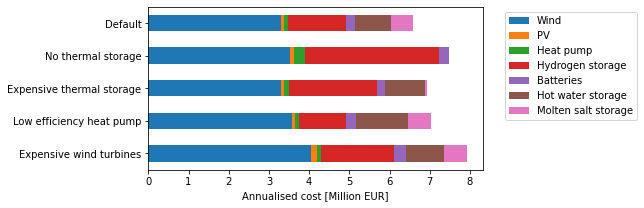

In [5]:
ax = costs.plot.barh(stacked=True, figsize=(6, 3))
handles, labels = ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel("Annualised cost [Million EUR]")
plt.savefig("figures/cost_comparison.pdf", bbox_inches='tight')